# Bike Sharing dataset
- https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

- Target Variable: cnt (the total number of bikes rented)
- All other columns are features

## Organization
- 0. Imports
- 1. EDA
- 2. Define extrapolation regions
- 3. Train/test splits
- 4. Feature Selection
- 5. Training, Tuning, and Eval
- 6. Extrapolation
- 7. Visualizations, explanations, conclusions, etc.

# 0.0 Imports

### 0.1 Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import os

import zipfile

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

asset_dir = '/project_data/data_asset/'

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

### 0.2 Data

In [2]:
bikesharing = wslib.load_data('Bike-Sharing-Dataset.zip')

my_zip = zipfile.ZipFile(bikesharing)
my_zip.namelist()

# the hourly file has many more rows, which is better when we are looking for examples 

['Readme.txt', 'day.csv', 'hour.csv']

In [3]:
df_bike = pd.read_csv(my_zip.open('hour.csv'), parse_dates=['dteday'])
df_bike.drop(['instant'], axis=1, inplace=True)

# some initial preparation
df_bike['weathersit'] = df_bike['weathersit'].replace({1:'Great_weather', 2:'Fair_weather', 3:'Bad_weather', 4:'Terrible_weather'})
df_bike['season'] = df_bike['season'].replace({1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'})
df_bike['yr'] = df_bike['yr'].replace({0:2011, 1:2012})
df_bike['weekday'] = df_bike['weekday'].replace({0:'Sun', 1:'Mon', 2:'Tues', 3:'Wed', 4:'Thurs', 5:'Fri', 6:'Sat'})
df_bike['mnth'] = df_bike['mnth'].replace({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
df_bike['hr_buckets'] = pd.cut(df_bike['hr'], 4, labels=['Early_morning', 'Daytime', 'Midday', 'Evening'])

# df_bike.drop(['hr'], axis=1, inplace=True)

convert_dict = {'season':'category',
'yr':'category',
'mnth':'category',
'hr_buckets':'category',
'holiday':'category',
'weekday':'category',
'workingday':'category',
'weathersit':'category',
'casual':int,
'registered':int,
'cnt':int}

df_bike = df_bike.astype(convert_dict)

print(df_bike.shape)
df_bike.head()

(17379, 17)


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,hr_buckets
0,2011-01-01,Winter,2011,Jan,0,0,Sat,0,Great_weather,0.24,0.2879,0.81,0.0,3,13,16,Early_morning
1,2011-01-01,Winter,2011,Jan,1,0,Sat,0,Great_weather,0.22,0.2727,0.80,0.0,8,32,40,Early_morning
2,2011-01-01,Winter,2011,Jan,2,0,Sat,0,Great_weather,0.22,0.2727,0.80,0.0,5,27,32,Early_morning
3,2011-01-01,Winter,2011,Jan,3,0,Sat,0,Great_weather,0.24,0.2879,0.75,0.0,3,10,13,Early_morning
4,2011-01-01,Winter,2011,Jan,4,0,Sat,0,Great_weather,0.24,0.2879,0.75,0.0,0,1,1,Early_morning


### 0.3 Helper Functions

In [4]:
# helper functions

def examine_data_regions(df, target, train_test_percentile, extrapolate_percentile):
    '''
    Examine the data according to desired experimentation splits using percentiles for train/test and extrapolation
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            
        Returns:
            The shape of pandas dataframe for the extrapolation region
            The mean value of the target for the intended train/test data
            The mean value of the target for the extrapolation region
    '''
    
    shape    = df.loc[df[target] >= df[target].quantile(extrapolate_percentile)].shape
    
    mean_is  = df.loc[df[target] <= df[target].quantile(train_test_percentile)][target].mean()
    mean_oos = df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target].mean()
    
    return shape, mean_is, mean_oos


def violin_dist_plots(df, target, train_test_percentile, extrapolate_percentile, title, variable_name):
    '''
    Generate a violin plot of the overall data distribution of target variable. Also plot the regions of data used for training/testing and extrapolation.
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            title (string): The given title for the plot
            variable_name (string): name of the target variable in plain text for labeling purposes
    '''
    data = df[target].values
    q1, q3 = np.percentile(data, [25, 75])
    whisker_low = q1 - (q3 - q1) * 1.5
    whisker_high = q3 + (q3 - q1) * 1.5
    fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

    sns.violinplot(x=data, color='CornflowerBlue', ax=ax1)
    outliers = data[(data > whisker_high) | (data < whisker_low)]
    sns.scatterplot(x=outliers, y=0, marker='D', color='crimson', ax=ax1)

    sns.violinplot(x=df.loc[df[target] <= df[target].quantile(train_test_percentile)] [target].values, color='CornflowerBlue', ax=ax2)
    sns.violinplot(x=df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target].values, color='CornflowerBlue', ax=ax3)

    ax1.tick_params(labelbottom=True)
    ax2.tick_params(labelbottom=True)

    ax1.set_title(title)
    ax2.set_title('Data used for training & testing')
    ax3.set_title('Data used for extrapolation')
    plt.xlabel(variable_name)
    plt.tight_layout()
    plt.show()


def violin_dist_plots_2(df, target, train_test_percentile, extrapolate_percentile, title, variable_name):
    '''
    Generate a violin plot of the overall data distribution of target variable. Also plot the regions of data used for training/testing and extrapolation.
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            title (string): The given title for the plot
            variable_name (string): name of the target variable in plain text for labeling purposes
    '''
    data = df[target].values
    q1, q3 = np.percentile(data, [25, 75])
    whisker_low = q1 - (q3 - q1) * 1.5
    whisker_high = q3 + (q3 - q1) * 1.5
    fig, axes = plt.subplots(3, figsize=(10, 8), sharex=True)

    sns.violinplot(x=data, color='CornflowerBlue', ax=axes[0])
    outliers = data[(data > whisker_high) | (data < whisker_low)]
    sns.scatterplot(x=outliers, y=0, marker='D', color='crimson', ax=axes[0], label='Outliers')

    sns.violinplot(x=df.loc[df[target] <= df[target].quantile(train_test_percentile)] [target].values, color='CornflowerBlue', ax=axes[1])
    sns.violinplot(x=df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target].values, color='CornflowerBlue', ax=axes[2])

    axes[0].tick_params(labelbottom=True)
    axes[1].tick_params(labelbottom=True)

    axes[0].set_title(title)
    axes[1].set_title('Data used for training & testing')
    axes[2].set_title('Data used for extrapolation')
    plt.tight_layout()
    plt.xlabel(variable_name)
    axes[0].legend()
    plt.show()


def train_test_extrapolation_split(df, target, train_test_percentile, extrapolate_percentile):
    '''
    Split the data. 
    First, separate the data into to bins; one for training/testing, and one for extrapolation. 
    Next, create the 75/25 train/test split using scikit-learn function. 
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            
        Returns:
            X and y data (pandas dataframes) for Training
            X and y data (pandas dataframes) for Testing
            X and y data (pandas dataframes) for Extrapolation
    '''
    
    insample_X = df.loc[df[target] <=  df[target].quantile(train_test_percentile)].drop([target], axis=1)
    insample_y = df.loc[df[target] <=  df[target].quantile(train_test_percentile)][target]
    
    X_train, X_test, y_train, y_test = train_test_split(insample_X, insample_y, test_size=.25, random_state=12)
    
    X_extrapolate = df.loc[df[target] >  df[target].quantile(extrapolate_percentile)].drop([target], axis=1)
    y_extrapolate = df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target]
    
    return X_train, y_train, X_test, y_test, X_extrapolate, y_extrapolate 


def correlation_heatmap(data, features, annot=True):
    '''
    Plot a heatmap of the feature set
        Parameters:
            data (pandas dataframe): pandas dataframe of the feature set
            features (list): list of names to be included in the plot 
    '''
    fig, ax = plt.subplots(figsize=(13,13)) 
    fig = sns.heatmap(data[features].corr(), vmin=-1, vmax=1, center=0,
                     cmap=sns.diverging_palette(20, 220, n=200),
                     square=True,
                     annot=annot, ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    
def evaluations_lr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Linear Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    
    print('Linear Regression results on Train/Test')
    print('Number of features: ', model['linearregression'].n_features_in_)

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')

    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')
    
    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)

#     print(f'Extrapolation set RMSE: {extrapolation_rmse: .4f}')
        
    return train_rmse, test_rmse, extrapolation_rmse
    
    
def evaluations_rfr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Random Forest Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    print('Random Forest results on Train/Test')
    print(model['randomforestregressor'])

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')
    
    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')

    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)

        
    return train_rmse, test_rmse, extrapolation_rmse
        
def evaluations_dtr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Decision Tree Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    print('Decision Tree results on Train/Test')
    print(model['decisiontreeregressor'])

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')

    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')  
    
    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)
        
    return train_rmse, test_rmse, extrapolation_rmse
    
    
def evaluations_hgbr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Histogram Gradient Boosting Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    print('Hist Grad Booster results on Train/Test')
    print(model['histgradientboostingregressor'])

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')

    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')
    
    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)

        
    return train_rmse, test_rmse, extrapolation_rmse


def plot_rmse_train_test(rmse_dict, split_number):
    '''
    Plot the RMSE values of the training and testing data
    
        Parameters:
            rmse_dict (dictionary): Python dictionary containing the model name and the RMSE values for the training and testing sets
            split_number (string or int): A value to help us give a proper title to the plot
    '''    
    labels = ['LR', 'RFR', 'DTR', 'HGBR']
    train = [round(c, 1) for c in rmse_dict['Train']]
    test  = [round(c, 1) for c in rmse_dict['Test']]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, train, width, label='Training')
    rects2 = ax.bar(x + width/2, test , width, label='Testing')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(f'RMSE by Model, Bike Data\nSplit {split_number}')
    ax.set_xlabel('Model')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x, labels)
    ax.set_yticks(np.arange(0,70,10))
    ax.legend()

    ax.bar_label(rects1, padding=2)
    ax.bar_label(rects2, padding=2)

    fig.tight_layout()

    plt.show()
    
    
def plot_rmse_train_test_extrap(rmse_dict, split_number, y_ticks=np.arange(0,350,50)):
    '''
    Plot the RMSE values of the training and testing data
    
        Parameters:
            rmse_dict (dictionary): Python dictionary containing the model name and the RMSE values for the training, testing, and extrapolation sets
            split_number (string or int): A value to help us give a proper title to the plot
    '''   
    
    labels = ['LR', 'RFR', 'DTR', 'HGBR']
    train = [round(c, 1) for c in rmse_dict['Train']]
    test  = [round(c, 1) for c in rmse_dict['Test']]
    extrap = [round(c, 1) for c in rmse_dict['Extrapolation']]

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, train , width, label='Training')
    rects2 = ax.bar(x        , test  , width, label='Testing')
    rects3 = ax.bar(x + width, extrap, width, label='Extrapolation')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(f'RMSE by Model, Bike Data\nSplit {split_number}')
    ax.set_xlabel('Model')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x, labels)
#     ax.set_yticks(np.arange(0,350,50))
    ax.set_yticks(y_ticks)
    ax.legend(loc=1)

#     ax.bar_label(rects1, padding=2)
#     ax.bar_label(rects2, padding=2)
#     ax.bar_label(rects3, padding=2)

    fig.tight_layout()


    plt.show()
    
    
def plot_relative_perf(rmse_dict, use_case, y_ticks=np.arange(0,12,2)):
    '''
    Plot relative performance change between the extrapolation and testing data
    
        Parameters:
            rmse_dict (dictionary): Python dictionary containing the model name and the RMSE values for the training, testing, and extrapolation sets
            use_case (string or int): The name of the use case, used for the title
    '''   
    fig, ax = plt.subplots()
    
    labels = ['LR', 'RFR', 'DTR', 'HGBR']
    performance_decreases = [round(i / j, 2) for i, j in zip(rmse_dict['Extrapolation'], rmse_dict['Test'])]

    bars = ax.bar(labels, performance_decreases, width=.4, color='purple')
    ax.bar_label(bars)

    ax.set_yticks(y_ticks)
    plt.xlabel('Model')
    plt.ylabel('Extrapolation RMSE / Test RMSE')
    plt.title(f'Relative Performance Decline by Model in Extrapolation \n {use_case}')
    plt.show()


# 1.0 Exploratory Data Analysis

In [5]:
# check missing values

df_bike.isna().any().value_counts(dropna=False)

# no missing values

False    17
dtype: int64

## Feature Engineering
- Build a few features to describe the past few hours of bike data

In [6]:
# build a few columns that describe the last 3 hours of renters

df_bike['casual_lag1'] = df_bike['casual'].shift(1)
df_bike['casual_lag2'] = df_bike['casual'].shift(2)
df_bike['casual_lag3'] = df_bike['casual'].shift(3)
df_bike['registered_lag1'] = df_bike['registered'].shift(1)
df_bike['registered_lag2'] = df_bike['registered'].shift(2)
df_bike['registered_lag3'] = df_bike['registered'].shift(3)

df_bike.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,hr_buckets,casual_lag1,casual_lag2,casual_lag3,registered_lag1,registered_lag2,registered_lag3
0,2011-01-01,Winter,2011,Jan,0,0,Sat,0,Great_weather,0.24,0.2879,0.81,0.0,3,13,16,Early_morning,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-01,Winter,2011,Jan,1,0,Sat,0,Great_weather,0.22,0.2727,0.80,0.0,8,32,40,Early_morning,3.0,NaN,NaN,13.0,NaN,NaN
2,2011-01-01,Winter,2011,Jan,2,0,Sat,0,Great_weather,0.22,0.2727,0.80,0.0,5,27,32,Early_morning,8.0,3.0,NaN,32.0,13.0,NaN
3,2011-01-01,Winter,2011,Jan,3,0,Sat,0,Great_weather,0.24,0.2879,0.75,0.0,3,10,13,Early_morning,5.0,8.0,3.0,27.0,32.0,13.0
4,2011-01-01,Winter,2011,Jan,4,0,Sat,0,Great_weather,0.24,0.2879,0.75,0.0,0,1,1,Early_morning,3.0,5.0,8.0,10.0,27.0,32.0


In [7]:
# these 2 columns need to be dropped since they are direct measures of the target

df_bike.drop(['casual','registered'], axis=1, inplace=True)
df_bike.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,hr_buckets,casual_lag1,casual_lag2,casual_lag3,registered_lag1,registered_lag2,registered_lag3
0,2011-01-01,Winter,2011,Jan,0,0,Sat,0,Great_weather,0.24,0.2879,0.81,0.0,16,Early_morning,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-01,Winter,2011,Jan,1,0,Sat,0,Great_weather,0.22,0.2727,0.80,0.0,40,Early_morning,3.0,NaN,NaN,13.0,NaN,NaN
2,2011-01-01,Winter,2011,Jan,2,0,Sat,0,Great_weather,0.22,0.2727,0.80,0.0,32,Early_morning,8.0,3.0,NaN,32.0,13.0,NaN
3,2011-01-01,Winter,2011,Jan,3,0,Sat,0,Great_weather,0.24,0.2879,0.75,0.0,13,Early_morning,5.0,8.0,3.0,27.0,32.0,13.0
4,2011-01-01,Winter,2011,Jan,4,0,Sat,0,Great_weather,0.24,0.2879,0.75,0.0,1,Early_morning,3.0,5.0,8.0,10.0,27.0,32.0


# 2.0 Define Extrapolation Regions

### 2.1 Standard Split
- Train/Test: [0-90]
- Extrapolate: (90-100]

Number of rows >= 90.0 percentile: 1738
Mean of target in train/test region:  144.5433
Mean of target in extrapolation region:  593.7152


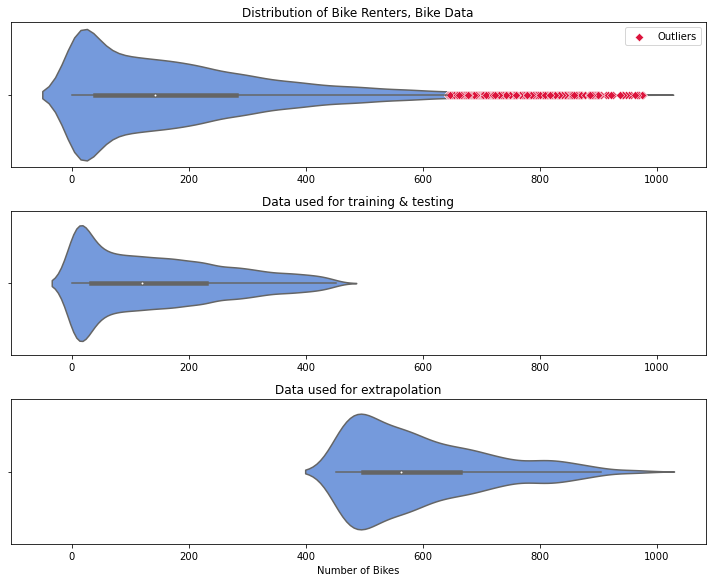

In [8]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex0 = .90
split_percentile_extrap_ex0 = .90


shape_0, mean_is_0, mean_oos_0 = examine_data_regions(df_bike, 'cnt', split_percentile_train_test_ex0, split_percentile_extrap_ex0)

print(f'Number of rows >= {split_percentile_extrap_ex0*100} percentile: {shape_0[0]}')
print(f'Mean of target in train/test region: {mean_is_0: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_0: .4f}')

violin_dist_plots_2(df_bike, 
                    'cnt', 
                    split_percentile_train_test_ex0, 
                    split_percentile_extrap_ex0, 
                    'Distribution of Bike Renters, Bike Data', 
                    'Number of Bikes')

### 2.2 Experiment Split 1 (low)
- Train/Test: [0-80]
- Leave out: (80-90]
- Extrapolate: (90-100]

Number of rows >= 91.0 percentile: 1569
Mean of target in train/test region:  115.3256
Mean of target in extrapolation region:  609.0090


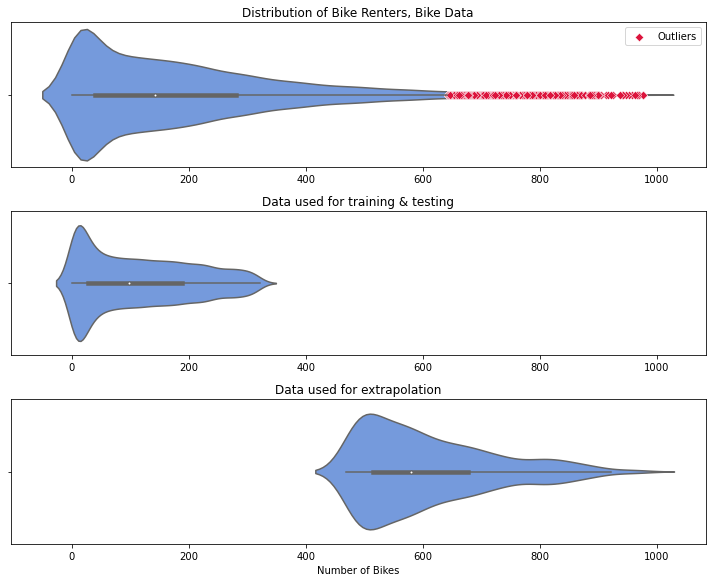

In [9]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex1 = .80
split_percentile_extrap_ex1 = .91


shape_1, mean_is_1, mean_oos_1 = examine_data_regions(df_bike, 'cnt', split_percentile_train_test_ex1, split_percentile_extrap_ex1)

print(f'Number of rows >= {split_percentile_extrap_ex1*100} percentile: {shape_1[0]}')
print(f'Mean of target in train/test region: {mean_is_1: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_1: .4f}')


violin_dist_plots_2(df_bike, 
                    'cnt', 
                    split_percentile_train_test_ex1, 
                    split_percentile_extrap_ex1, 
                    'Distribution of Bike Renters, Bike Data', 
                    'Number of Bikes')

### 2.3 Experiment Split 2 (moderate)
- Train/Test: [0-70]
- Leave out: (70-85]
- Extrapolate: (85-100]

Number of rows >= 86.0 percentile: 2436
Mean of target in train/test region:  91.5876
Mean of target in extrapolation region:  543.7918


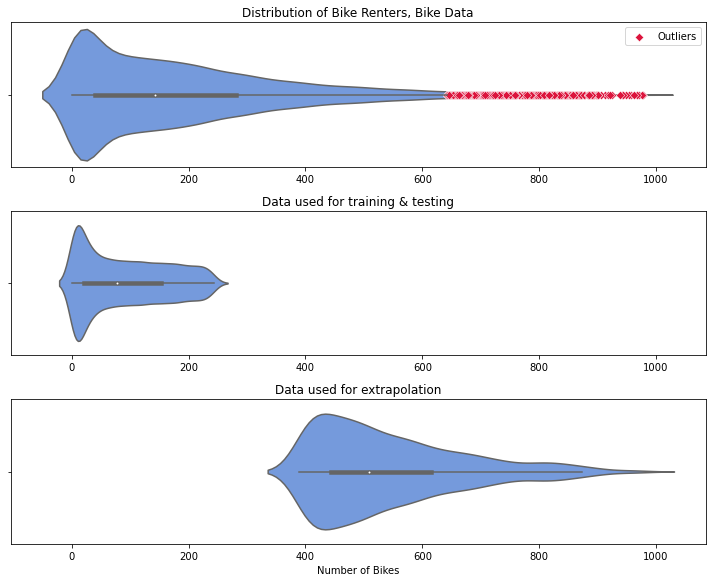

In [10]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex2 = .70
split_percentile_extrap_ex2 = .86

shape_2, mean_is_2, mean_oos_2 = examine_data_regions(df_bike, 'cnt', split_percentile_train_test_ex2, split_percentile_extrap_ex2)

print(f'Number of rows >= {split_percentile_extrap_ex2*100} percentile: {shape_2[0]}')
print(f'Mean of target in train/test region: {mean_is_2: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_2: .4f}')


violin_dist_plots_2(df_bike, 
                    'cnt', 
                    split_percentile_train_test_ex2, 
                    split_percentile_extrap_ex2, 
                    'Distribution of Bike Renters, Bike Data', 
                    'Number of Bikes')

### 2.4 Experiment Split 3 (extreme)
- Train/Test: [0-60]
- Leave out: (60-90]
- Extrapolate: (90-100]

Number of rows >= 95.0 percentile: 869
Mean of target in train/test region:  70.9852
Mean of target in extrapolation region:  686.0955


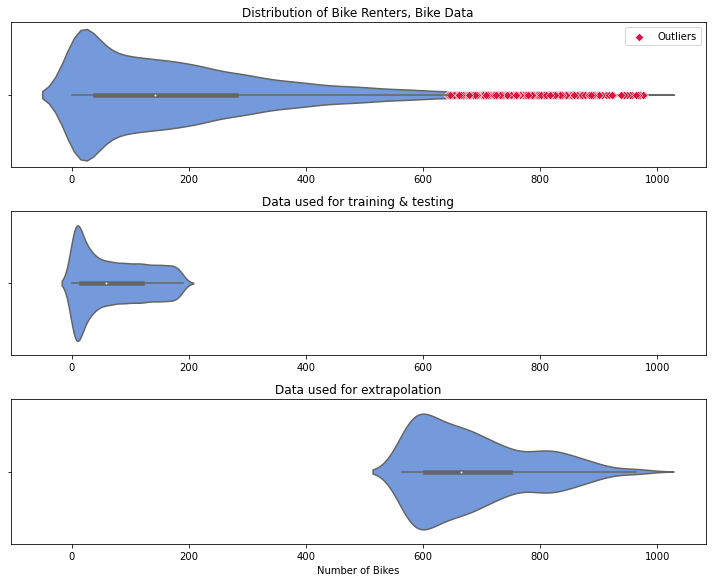

In [11]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex3 = .60
split_percentile_extrap_ex3 = .95

shape_3, mean_is_3, mean_oos_3 = examine_data_regions(df_bike, 'cnt', split_percentile_train_test_ex3, split_percentile_extrap_ex3)

print(f'Number of rows >= {split_percentile_extrap_ex3*100} percentile: {shape_3[0]}')
print(f'Mean of target in train/test region: {mean_is_3: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_3: .4f}')

violin_dist_plots_2(df_bike, 
                    'cnt', 
                    split_percentile_train_test_ex3, 
                    split_percentile_extrap_ex3, 
                    'Distribution of Bike Renters, Bike Data', 
                    'Number of Bikes')

# 3.0 Train/Test/Extrapolation Splits

In [12]:
# standard split

X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0 = train_test_extrapolation_split(df_bike, 'cnt', .9, .9)

print(X_train_0.shape)
print(X_test_0.shape)
print(X_extrap_0.shape)

(11730, 20)
(3911, 20)
(1738, 20)


In [13]:
# experiment 1 -- low 
X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1 = train_test_extrapolation_split(df_bike, 'cnt', .8, .91)

print(X_train_1.shape)
print(X_test_1.shape)
print(X_extrap_1.shape)

(10431, 20)
(3477, 20)
(1560, 20)


In [14]:
# experiment 2 -- moderate

X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2 = train_test_extrapolation_split(df_bike, 'cnt', .7, .86)

print(X_train_2.shape)
print(X_test_2.shape)
print(X_extrap_2.shape)

(9127, 20)
(3043, 20)
(2425, 20)


In [15]:
# experiment 3 -- extreme

X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3 = train_test_extrapolation_split(df_bike, 'cnt', .6, .95)

print(X_train_3.shape)
print(X_test_3.shape)
print(X_extrap_3.shape)

(7833, 20)
(2611, 20)
(869, 20)


# 4.0 Feature Selection

### 4.1 Find the set of uncorrelated columns

In [16]:

corr_matrix = X_train_3.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print('Number of columns to remove: ', len(to_drop))
print('\n')
print(to_drop)

Number of columns to remove:  5


['atemp', 'casual_lag2', 'casual_lag3', 'registered_lag2', 'registered_lag3']


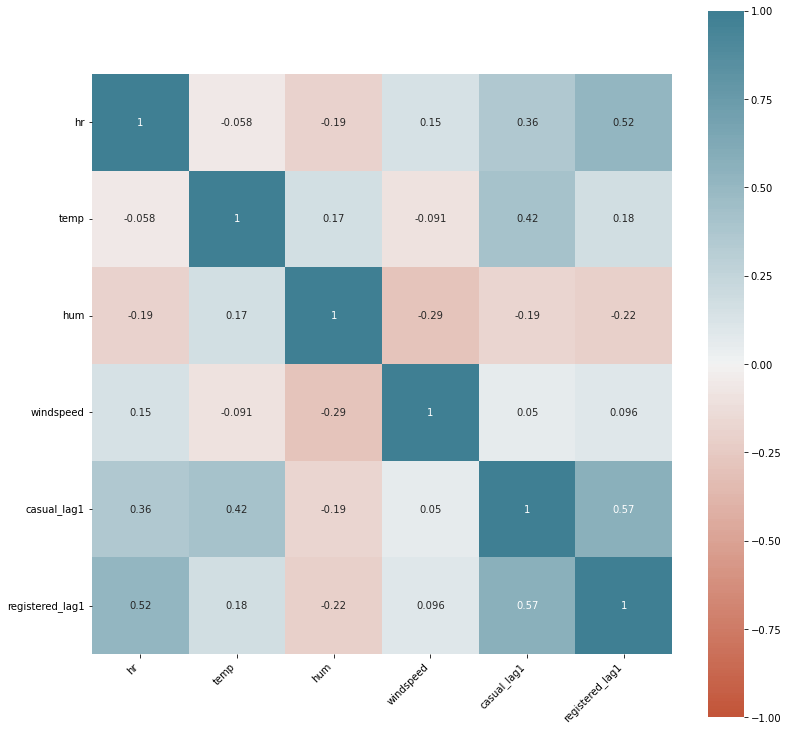

In [17]:
# correlation_heatmap(df_spr, list(selector.get_feature_names_out())+['critical_temp'])
# # need to drop columns that are to_drop

correlation_heatmap(X_train_3, [c for c in X_train_3.columns if c not in to_drop])


### 4.2 Check the Mutual Information

In [18]:
mi = mutual_info_regression(X_train_3[[c for c in upper_tri.columns if c not in to_drop]].fillna(0), y_train_3)

mutual_info = pd.DataFrame(index=X_train_3[[c for c in upper_tri.columns if c not in to_drop]].columns, 
                           data={'Mutual_info': mi}).sort_values(by='Mutual_info', ascending=False)

# get some general information about the mutual information
mutual_info.describe()


,Mutual_info
count,6.000000
mean,0.261509
std,0.261268
min,0.005758
25%,0.059279
50%,0.191468
75%,0.439345
max,0.643173


# 5.0 Training, Tuning, Evaluation

- Note: Some of the grid search is commented out after finding the best features to make rerunning faster

### Make lists for preprocessing

In [19]:
target = ['cnt']
index = ['dteday']
features = [c for c in df_bike.columns if c not in target+index+to_drop]

cat_feats = [c for c in features if df_bike[c].dtype.name=='category' and df_bike[c].nunique()>2]
print(f'Categorical feats: {cat_feats}')

binary_feats = [c for c in features if df_bike[c].nunique()==2 and c not in cat_feats]
print(f'Binary features: {binary_feats}')

num_feats = df_bike[features].select_dtypes('number').columns.tolist()
print(f'Num feats: {num_feats}')


Categorical feats: ['season', 'mnth', 'weekday', 'weathersit', 'hr_buckets']
Binary features: ['yr', 'holiday', 'workingday']
Num feats: ['hr', 'temp', 'hum', 'windspeed', 'casual_lag1', 'registered_lag1']


In [20]:
def define_preprocessor(num_feats, cat_feats, binary_feats):
    
    num_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), StandardScaler())
    
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse=False))
    
    binary_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())
    
    preprocessor = make_column_transformer((num_pipe, num_feats), 
                                           (cat_pipe, cat_feats), 
                                           (binary_pipe, binary_feats), 
                                           remainder='drop')
    
    return preprocessor

In [21]:
my_preprocessor = define_preprocessor(num_feats, cat_feats, binary_feats)
my_preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['hr', 'temp', 'hum', 'windspeed',
                                  'casual_lag1', 'registered_lag1']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['season', 'mnth', 'weekday', 'weathersit',
            

### 5.1 Linear Regression

In [22]:
# standard case

# define the model
lr_model_0 = LinearRegression()
pipe_lr_0 = make_pipeline(my_preprocessor, lr_model_0)

# fit the model
pipe_lr_0.fit(X_train_0, y_train_0)

# get some eval information
train_rmse_lr_0, test_rmse_lr_0, extrapolation_rmse_lr_0 = evaluations_lr(pipe_lr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)


Linear Regression results on Train/Test
Number of features:  40
Train set RMSE:  55.5157
Test set RMSE:  54.1922


[-2.33092522e+01  7.09212817e+00 -5.44197251e-01 -7.01738391e-01
  4.09603657e+01  5.45034673e+01  7.98961781e+12  7.98961781e+12
  7.98961781e+12  7.98961781e+12 -2.52516706e+13 -2.52516706e+13
 -2.52516706e+13 -2.52516706e+13 -2.52516706e+13 -2.52516706e+13
 -2.52516706e+13 -2.52516706e+13 -2.52516706e+13 -2.52516706e+13
 -2.52516706e+13 -2.52516706e+13  4.55491336e+12  4.55491336e+12
  1.30562307e+13  1.30562307e+13  4.55491336e+12  4.55491336e+12
  4.55491336e+12  1.62210072e+13  1.62210072e+13  1.62210072e+13
  1.62210072e+13 -5.04775850e+13 -5.04775850e+13 -5.04775850e+13
 -5.04775850e+13  1.48168612e+01  8.50131733e+12  8.50131733e+12]


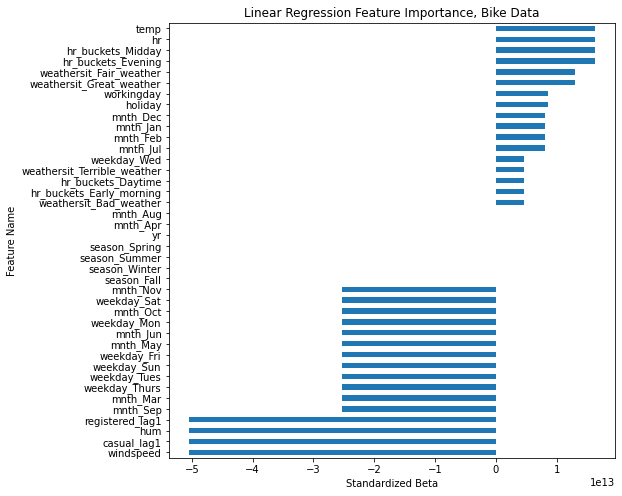

In [23]:
# get feature importances
# standard case

print(pipe_lr_0.named_steps['linearregression'].coef_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_0[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(pipe_lr_0.named_steps['linearregression'].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Bike Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


In [24]:
# first case

# define the model
lr_model_1 = LinearRegression()
pipe_lr_1 = make_pipeline(my_preprocessor, lr_model_1)

# fit the model
pipe_lr_1.fit(X_train_1, y_train_1)

# get some eval information
# train_rmse_lr_1, test_rmse_lr_1 = evaluations_lr(best_model_lr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_lr_1, test_rmse_lr_1, extrapolation_rmse_lr_1 = evaluations_lr(pipe_lr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)


Linear Regression results on Train/Test
Number of features:  40
Train set RMSE:  41.6077
Test set RMSE:  43.1336


[-1.72634314e+01  6.28014316e+00 -1.37536458e+00 -8.60268863e-01
  2.77734982e+01  3.99881241e+01  3.79131813e+11  3.79131813e+11
  3.79131813e+11  3.79131813e+11 -4.38931337e+10 -4.38931337e+10
 -4.38931337e+10 -4.38931337e+10 -4.38931337e+10 -4.38931337e+10
 -4.38931337e+10 -4.38931337e+10 -4.38931337e+10 -4.38931337e+10
 -4.38931337e+10 -4.38931337e+10 -1.12581997e+10 -1.12581997e+10
 -7.56355008e+10 -7.56355008e+10 -1.12581997e+10 -1.12581997e+10
 -1.12581997e+10  4.91293053e+09  4.91293055e+09  4.91293055e+09
  4.91293056e+09 -7.50127430e+11 -7.50127430e+11 -7.50127430e+11
 -7.50127430e+11  1.24648189e+01 -6.43773010e+10 -6.43773010e+10]


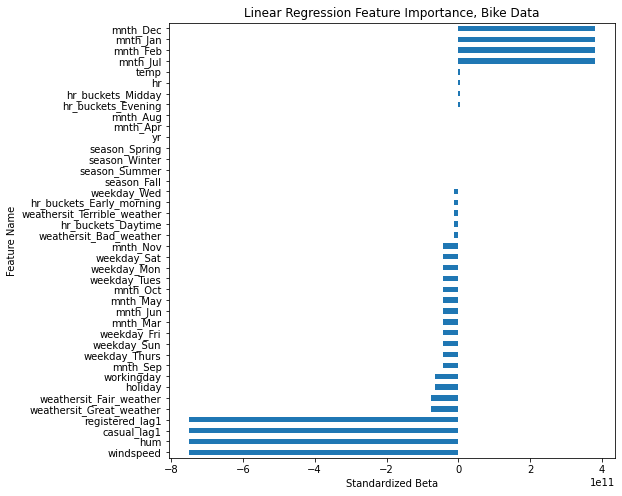

In [25]:
# get feature importances
# first case

print(pipe_lr_1.named_steps['linearregression'].coef_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_1[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(pipe_lr_1.named_steps['linearregression'].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Bike Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


In [26]:
# second case

# define the model
lr_model_2 = LinearRegression()
pipe_lr_2 = make_pipeline(my_preprocessor, lr_model_2)

# fit the model
pipe_lr_2.fit(X_train_2, y_train_2)

# get some eval information
# train_rmse_lr_2, test_rmse_lr_2 = evaluations_lr(best_model_lr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_lr_2, test_rmse_lr_2, extrapolation_rmse_lr_2 = evaluations_lr(pipe_lr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)


Linear Regression results on Train/Test
Number of features:  40
Train set RMSE:  33.2874
Test set RMSE:  33.0355


[-1.45041570e+01  5.57896295e+00 -1.60723427e+00 -1.82396576e-01
  1.84630117e+01  3.21456277e+01 -5.98324209e+12 -5.98324209e+12
 -5.98324209e+12 -5.98324209e+12  3.45324792e+11  3.45324792e+11
  3.45324792e+11  3.45324792e+11  3.45324792e+11  3.45324792e+11
  3.45324792e+11  3.45324792e+11  3.45324792e+11  3.45324792e+11
  3.45324792e+11  3.45324792e+11  1.56938113e+12  1.56938113e+12
 -3.32860131e+11 -3.32860131e+11  1.56938113e+12  1.56938113e+12
  1.56938113e+12  4.73437681e+12  4.73437681e+12  4.73437681e+12
  4.73437681e+12 -1.07179063e+13 -1.07179063e+13 -1.07179063e+13
 -1.07179063e+13  1.15924528e+01 -1.90224126e+12 -1.90224126e+12]


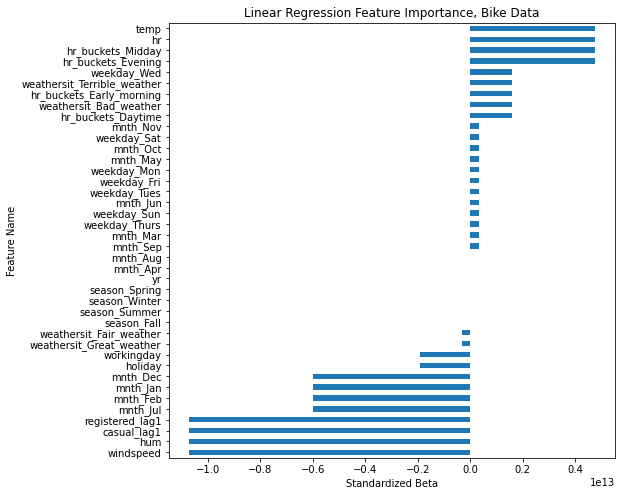

In [27]:
# get feature importances
# second case

print(pipe_lr_2.named_steps['linearregression'].coef_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_2[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(pipe_lr_2.named_steps['linearregression'].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Bike Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


In [28]:
# third case

# define the model
lr_model_3 = LinearRegression()
pipe_lr_3 = make_pipeline(my_preprocessor, lr_model_3)

# fit the model
pipe_lr_3.fit(X_train_3, y_train_3)

# get some eval information
# train_rmse_lr_3, test_rmse_lr_3 = evaluations_lr(best_model_lr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_lr_3, test_rmse_lr_3, extrapolation_rmse_lr_3 = evaluations_lr(pipe_lr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)



Linear Regression results on Train/Test
Number of features:  40
Train set RMSE:  27.2093
Test set RMSE:  27.8633


[-1.48007489e+01  5.05303568e+00 -9.78631029e-01 -3.15329953e-01
  1.12014765e+01  2.60645994e+01  7.77697006e+12  7.77697006e+12
  7.77697006e+12  7.77697006e+12  5.25459172e+12  5.25459172e+12
  5.25459172e+12  5.25459172e+12  5.25459172e+12  5.25459172e+12
  5.25459172e+12  5.25459172e+12  5.25459172e+12  5.25459172e+12
  5.25459172e+12  5.25459172e+12  4.81796037e+12  4.81796037e+12
  1.44952906e+13  1.44952906e+13  4.81796037e+12  4.81796037e+12
  4.81796037e+12  7.37574199e+12  7.37574199e+12  7.37574199e+12
  7.37574199e+12  5.31565593e+13  5.31565593e+13  5.31565593e+13
  5.31565593e+13  7.27760270e+00  9.67733021e+12  9.67733021e+12]


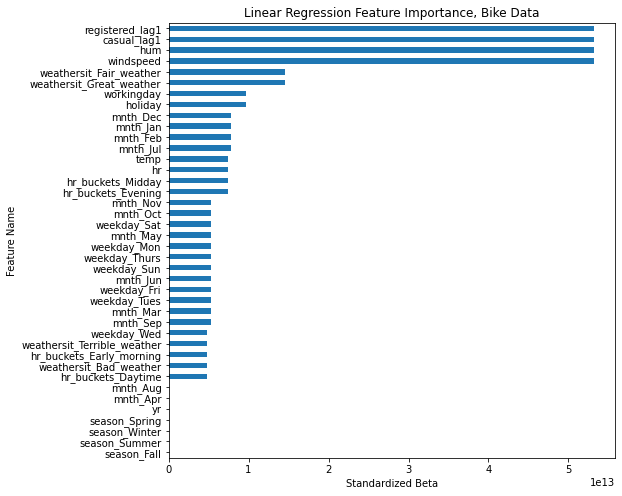

In [29]:
# get feature importances
# third case

print(pipe_lr_3.named_steps['linearregression'].coef_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_3[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(pipe_lr_3.named_steps['linearregression'].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Bike Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


### 5.2 Random Forest Model

In [30]:
# define the model

rfr_model = RandomForestRegressor(criterion='squared_error', random_state=12)
pipe_rfr = make_pipeline(my_preprocessor, rfr_model)

kfold = KFold(n_splits=3, shuffle=True, random_state=12)


In [31]:
# standard case

# build the folds for cross validation
cv_generator = kfold.split(X_train_0, y_train_0)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(65, 85, 5)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(12,16,3)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(12,20,4)).astype(int)}


param_grid = {'randomforestregressor__n_estimators':[75],
              'randomforestregressor__max_depth':[16], 
              'randomforestregressor__min_samples_leaf':[12]}



grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_rfr.fit(X_train_0, y_train_0)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_0 = grid_rfr.best_estimator_

# train_rmse_rfr_0, test_rmse_rfr_0 = evaluations_rfr(best_model_rfr_0, X_train_0, y_train_0, X_test_0, y_test_0)
train_rmse_rfr_0, test_rmse_rfr_0, extrapolation_rmse_rfr_0 = evaluations_rfr(best_model_rfr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9315
Best parameters: {'randomforestregressor__max_depth': 16, 'randomforestregressor__min_samples_leaf': 12, 'randomforestregressor__n_estimators': 75}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=16, min_samples_leaf=12, n_estimators=75,
                      random_state=12)
Train set RMSE:  26.2421
Test set RMSE:  29.5766


[1.16846100e-01 4.46649441e-03 2.13713015e-03 1.09287771e-03
 6.93191869e-02 7.39853599e-01 3.80688517e-04 1.09285276e-04
 1.48680949e-04 7.02659949e-04 5.67715783e-06 3.21462499e-05
 3.72633681e-05 1.06215424e-05 1.85735180e-05 8.36826723e-06
 2.05349484e-06 1.71018581e-05 7.63212780e-06 2.81902365e-05
 2.78174189e-05 1.27703299e-05 5.10594512e-04 9.84890730e-05
 1.94515298e-03 2.00801206e-04 2.66330580e-05 4.03154307e-05
 3.06876104e-05 5.45341881e-04 1.10661452e-04 2.54312985e-04
 0.00000000e+00 2.03345236e-03 2.51608612e-02 1.25528821e-02
 9.57677590e-03 4.03030646e-03 0.00000000e+00 7.61781341e-03]


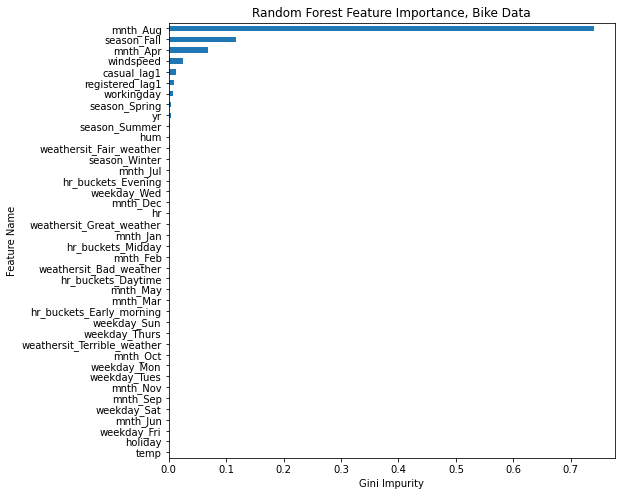

In [32]:
# get feature importance
# standard case

print(best_model_rfr_0.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_0[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(best_model_rfr_0.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Bike Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



In [33]:
# first case

# build the folds for cross validation
cv_generator = kfold.split(X_train_1, y_train_1)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(90, 99, 3)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(16,20,4)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(10,20,3)).astype(int)}


param_grid = {'randomforestregressor__n_estimators':[99],
              'randomforestregressor__max_depth':[18], 
              'randomforestregressor__min_samples_leaf':[10]}



grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_rfr.fit(X_train_1, y_train_1)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_1 = grid_rfr.best_estimator_

# train_rmse_rfr_1, test_rmse_rfr_1 = evaluations_rfr(best_model_rfr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_rfr_1, test_rmse_rfr_1, extrapolation_rmse_rfr_1 = evaluations_rfr(best_model_rfr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9210
Best parameters: {'randomforestregressor__max_depth': 18, 'randomforestregressor__min_samples_leaf': 10, 'randomforestregressor__n_estimators': 99}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=18, min_samples_leaf=10, n_estimators=99,
                      random_state=12)
Train set RMSE:  21.2209
Test set RMSE:  24.7962


[1.12336463e-01 5.98204560e-03 3.08479282e-03 1.88018653e-03
 8.00909870e-02 7.22224258e-01 4.31046887e-04 2.36574921e-04
 1.59865168e-04 1.21186681e-03 1.44979386e-05 5.22354607e-05
 6.51392942e-05 5.40076501e-05 9.39323121e-05 4.57262432e-05
 1.74969579e-05 5.49279798e-05 1.88308935e-05 1.55115398e-05
 5.19203818e-05 5.53875427e-05 6.35334368e-04 9.55637095e-05
 6.70252470e-04 3.20536138e-04 9.14899110e-05 1.62018839e-04
 7.32620888e-05 1.54549421e-03 2.50480385e-04 4.67672759e-04
 0.00000000e+00 5.11812087e-03 3.41223788e-02 8.67345281e-03
 4.36159240e-03 5.23097581e-03 0.00000000e+00 1.00036735e-02]


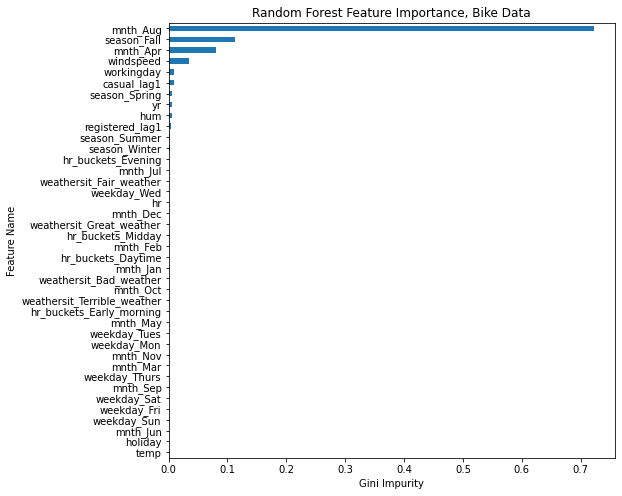

In [34]:
# get feature importance
# first case

print(best_model_rfr_1.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_1[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(best_model_rfr_1.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Bike Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



In [35]:
# second case

# build the folds for cross validation
cv_generator = kfold.split(X_train_2, y_train_2)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(75, 82, 5)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(10,14,4)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(17,21,3)).astype(int)}


param_grid = {'randomforestregressor__n_estimators':[90],
              'randomforestregressor__max_depth':[16], 
              'randomforestregressor__min_samples_leaf':[14]}



grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_rfr.fit(X_train_2, y_train_2)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_2 = grid_rfr.best_estimator_

# train_rmse_rfr_2, test_rmse_rfr_2 = evaluations_rfr(best_model_rfr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_rfr_2, test_rmse_rfr_2, extrapolation_rmse_rfr_2 = evaluations_rfr(best_model_rfr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9077
Best parameters: {'randomforestregressor__max_depth': 16, 'randomforestregressor__min_samples_leaf': 14, 'randomforestregressor__n_estimators': 90}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=16, min_samples_leaf=14, n_estimators=90,
                      random_state=12)
Train set RMSE:  19.0150
Test set RMSE:  21.4655


[1.09396700e-01 6.98619350e-03 2.38644346e-03 1.23067292e-03
 4.90873152e-02 7.31330454e-01 5.14134933e-04 2.33395331e-04
 1.02346036e-04 1.06602156e-03 1.04407119e-06 2.32105426e-05
 2.39055477e-05 3.20871915e-05 5.21455266e-05 1.19779308e-05
 2.92689670e-05 3.43544840e-05 8.55678383e-06 2.47404831e-05
 1.14448259e-05 1.05735486e-05 5.74215272e-04 9.03517875e-05
 1.35383754e-03 2.46719399e-04 4.40351888e-05 8.80069651e-05
 8.01202517e-05 2.51184345e-03 1.03813985e-04 4.78460390e-04
 0.00000000e+00 1.32070845e-02 4.01671388e-02 9.05012686e-03
 1.82400882e-02 2.91779085e-03 0.00000000e+00 8.24937985e-03]


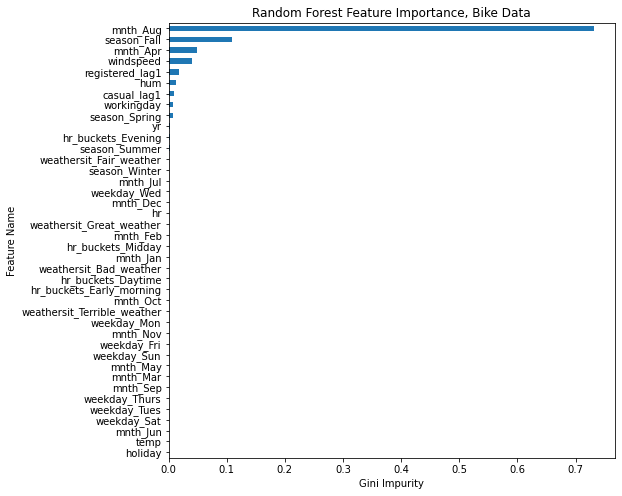

In [36]:
# get feature importance
# second case

print(best_model_rfr_2.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_2[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(best_model_rfr_2.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Bike Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



In [37]:
# third case

# build the folds for cross validation
cv_generator = kfold.split(X_train_3, y_train_3)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(100, 120, 5)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(12,18,4)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(15,25,3)).astype(int)}


param_grid = {'randomforestregressor__n_estimators':[94],
              'randomforestregressor__max_depth':[12], 
              'randomforestregressor__min_samples_leaf':[15]}



grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_rfr.fit(X_train_3, y_train_3)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_3 = grid_rfr.best_estimator_

# train_rmse_rfr_3, test_rmse_rfr_3 = evaluations_rfr(best_model_rfr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_rfr_3, test_rmse_rfr_3, extrapolation_rmse_rfr_3 = evaluations_rfr(best_model_rfr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.8924
Best parameters: {'randomforestregressor__max_depth': 12, 'randomforestregressor__min_samples_leaf': 15, 'randomforestregressor__n_estimators': 94}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=12, min_samples_leaf=15, n_estimators=94,
                      random_state=12)
Train set RMSE:  16.3823
Test set RMSE:  18.7344


[1.33352816e-01 7.12560933e-03 2.69930833e-03 1.46451615e-03
 3.65182007e-02 7.02578813e-01 3.67067698e-04 2.03145018e-04
 1.25011936e-04 2.25627321e-03 3.35907335e-06 3.82153544e-05
 4.28569203e-06 4.18602568e-06 4.47364062e-05 1.16461567e-05
 1.65117412e-06 5.10949962e-05 9.76996448e-06 1.21288398e-05
 7.43348505e-07 2.24926134e-06 5.45120936e-04 4.34691275e-05
 6.16591057e-04 3.63570693e-04 2.22669669e-05 1.02241213e-04
 1.10822832e-04 2.71673141e-03 1.81345703e-04 8.06193534e-04
 0.00000000e+00 1.04291590e-02 6.34993085e-02 5.51810779e-03
 1.72703350e-02 1.66032090e-03 0.00000000e+00 9.23958755e-03]


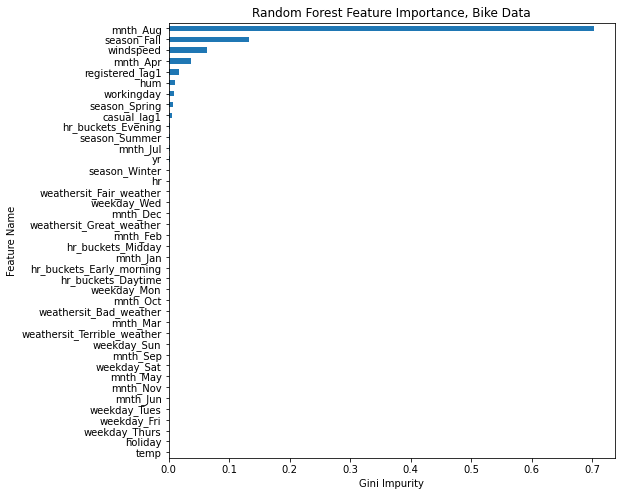

In [38]:
# get feature importance
# third case

print(best_model_rfr_3.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_3[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(best_model_rfr_3.steps[1][1].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Bike Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



### 5.3 Decision Tree Model

In [39]:
# define the model

dtr_model = DecisionTreeRegressor(criterion='squared_error', random_state=12)
pipe_dtr = make_pipeline(my_preprocessor, dtr_model)

kfold = KFold(n_splits=5, shuffle=True, random_state=12)

In [40]:
# standard case

# build the folds for cross validation
cv_generator = kfold.split(X_train_0, y_train_0)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(8,12,3)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(12,18,3)).astype(int)}

param_grid = {'decisiontreeregressor__max_depth':[12], 
              'decisiontreeregressor__min_samples_leaf':[12]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_0, y_train_0)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_0 = grid_dtr.best_estimator_

# train_rmse_dtr_0, test_rmse_dtr_0 = evaluations_dtr(best_model_dtr_0, X_train_0, y_train_0, X_test_0, y_test_0)
train_rmse_dtr_0, test_rmse_dtr_0, extrapolation_rmse_dtr_0 = evaluations_dtr(best_model_dtr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.9154


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=12, min_samples_leaf=12, random_state=12)
Train set RMSE:  27.6771
Test set RMSE:  32.5952


[1.26209986e-01 4.62514624e-03 1.40703861e-03 3.54430218e-04
 6.58533572e-02 7.36569580e-01 1.63550550e-04 7.85878136e-05
 3.31927317e-05 9.12040011e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.33775394e-06 2.46054987e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.68184079e-06 1.86349235e-05
 0.00000000e+00 0.00000000e+00 5.92394680e-04 1.44160300e-04
 2.56425091e-03 3.44244965e-05 0.00000000e+00 7.92087217e-05
 2.13231964e-07 1.09186575e-03 1.29786294e-04 2.02842088e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.49753129e-02
 9.46536617e-03 4.98224225e-03 0.00000000e+00 9.50312256e-03]


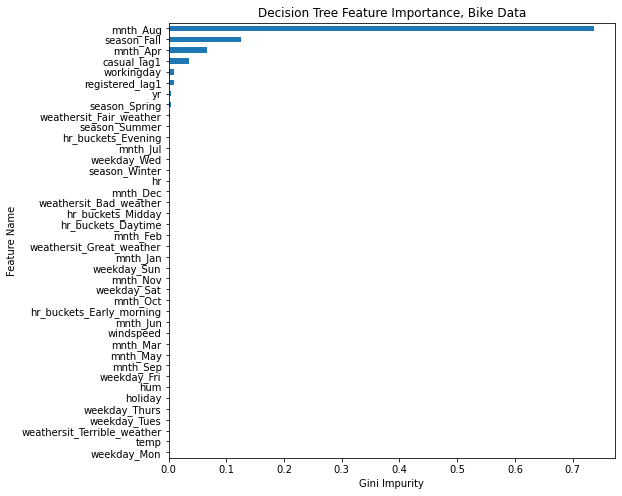

In [41]:
# feature importance plot
# standard case

print(best_model_dtr_0.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_0[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(best_model_dtr_0.named_steps['decisiontreeregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Bike Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



In [42]:
# first case

# build the folds for cross validation
cv_generator = kfold.split(X_train_1, y_train_1)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(8,12,3)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(14,25,4)).astype(int)}

param_grid = {'decisiontreeregressor__max_depth':[12], 
              'decisiontreeregressor__min_samples_leaf':[14]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_1, y_train_1)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_1 = grid_dtr.best_estimator_

# train_rmse_dtr_1, test_rmse_dtr_1 = evaluations_dtr(best_model_dtr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_dtr_1, test_rmse_dtr_1, extrapolation_rmse_dtr_1 = evaluations_dtr(best_model_dtr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.9013


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=12, min_samples_leaf=14, random_state=12)
Train set RMSE:  24.5419
Test set RMSE:  28.3623


[1.25738194e-01 4.83673576e-03 1.65111541e-03 1.26955913e-03
 7.88142992e-02 7.25402526e-01 2.31369089e-04 1.64198517e-04
 5.88100235e-05 5.70254288e-04 0.00000000e+00 3.16009221e-06
 0.00000000e+00 4.02226421e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.36448895e-06 0.00000000e+00
 1.71163250e-04 0.00000000e+00 5.34596783e-04 0.00000000e+00
 1.22760588e-03 3.96485453e-04 8.09822017e-05 3.22799658e-06
 2.55917775e-06 1.18124239e-03 1.66434373e-04 3.35654654e-04
 0.00000000e+00 3.44833081e-03 2.25968825e-02 1.44837517e-02
 1.75317027e-03 5.92617297e-03 0.00000000e+00 8.90393030e-03]


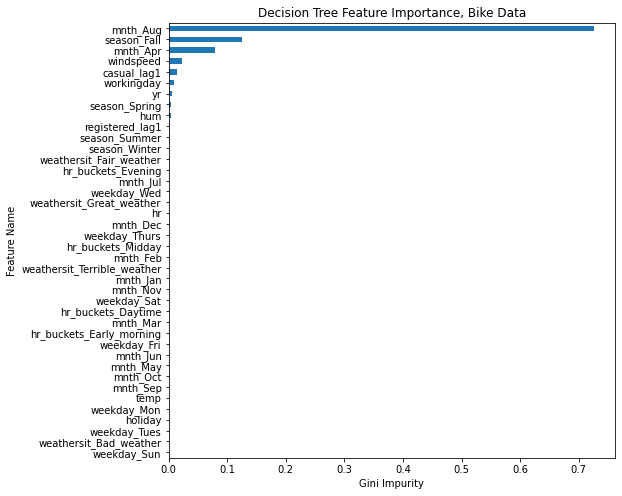

In [43]:
# feature importance plot
# first case

print(best_model_dtr_1.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_1[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(best_model_dtr_1.named_steps['decisiontreeregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Bike Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



In [44]:
# second case

# build the folds for cross validation
cv_generator = kfold.split(X_train_2, y_train_2)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(7,10,3)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(20,25,3)).astype(int)}

param_grid = {'decisiontreeregressor__max_depth':[10], 
              'decisiontreeregressor__min_samples_leaf':[20]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_2, y_train_2)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_2 = grid_dtr.best_estimator_

# train_rmse_dtr_2, test_rmse_dtr_2 = evaluations_dtr(best_model_dtr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_dtr_2, test_rmse_dtr_2, extrapolation_rmse_dtr_2 = evaluations_dtr(best_model_dtr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.8876


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=10, min_samples_leaf=20, random_state=12)
Train set RMSE:  21.4333
Test set RMSE:  23.9920


[1.57454459e-01 5.14278257e-03 1.38340225e-03 7.24560938e-04
 4.73078853e-02 7.32268452e-01 4.22894019e-04 8.68528382e-05
 0.00000000e+00 1.10068120e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.09909165e-04 0.00000000e+00
 1.04033737e-03 9.31501253e-05 0.00000000e+00 8.21811317e-05
 0.00000000e+00 1.64298793e-03 0.00000000e+00 2.52866890e-04
 0.00000000e+00 1.47345707e-02 2.99225579e-04 9.44509433e-03
 1.63731446e-02 1.54645856e-03 0.00000000e+00 8.08810386e-03]


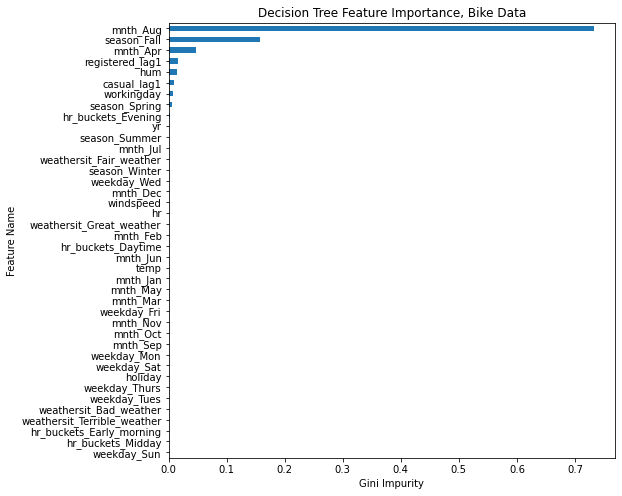

In [45]:
# feature importance plot
# second case

print(best_model_dtr_2.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_2[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(best_model_dtr_2.named_steps['decisiontreeregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Bike Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



In [46]:
# third case

# build the folds for cross validation
cv_generator = kfold.split(X_train_3, y_train_3)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(8,9,2)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(9,10,2)).astype(int)}

param_grid = {'decisiontreeregressor__max_depth':[8], 
              'decisiontreeregressor__min_samples_leaf':[10]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_3, y_train_3)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_3 = grid_dtr.best_estimator_

# train_rmse_dtr_3, test_rmse_dtr_3 = evaluations_dtr(best_model_dtr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_dtr_3, test_rmse_dtr_3, extrapolation_rmse_dtr_3 = evaluations_dtr(best_model_dtr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.8752


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=8, min_samples_leaf=10, random_state=12)
Train set RMSE:  17.6923
Test set RMSE:  20.7626


[1.88710089e-01 5.30527528e-03 8.38237808e-04 1.60150287e-04
 4.01061748e-02 7.05785149e-01 1.20073144e-04 1.74697278e-04
 0.00000000e+00 5.57056630e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28789699e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.19661647e-04 5.41052415e-04 2.03044219e-04
 1.76203452e-03 1.54488697e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.08235029e-03 0.00000000e+00 6.41766627e-04
 0.00000000e+00 1.18424289e-02 9.15918253e-03 1.37199632e-02
 9.52181133e-03 7.14893889e-04 0.00000000e+00 7.65162915e-03]


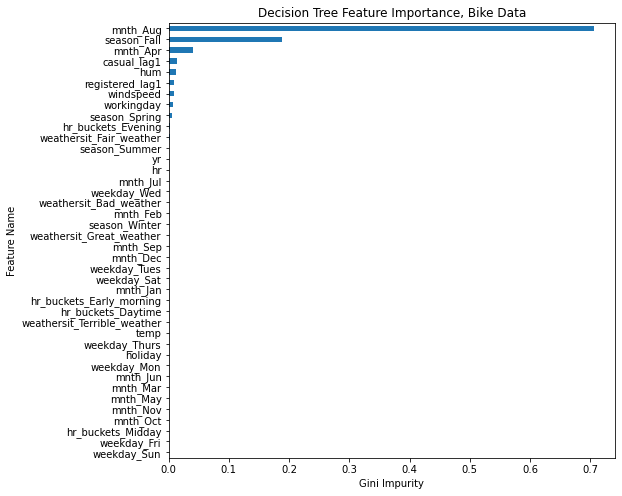

In [47]:
# feature importance plot
# first case

print(best_model_dtr_3.steps[1][1].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].named_steps['onehotencoder'].fit(X_train_3[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats + binary_feats

pd.Series(best_model_dtr_3.named_steps['decisiontreeregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Bike Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



### 5.4 Gradient Booster Regressor

In [48]:
# define the model

hgbr_model = HistGradientBoostingRegressor(loss='squared_error', random_state=12)
pipe_hgbr = make_pipeline(my_preprocessor, hgbr_model)

kfold = KFold(n_splits=3, shuffle=True, random_state=12)


In [49]:
# standard case

# build the folds for cross validation
cv_generator = kfold.split(X_train_0, y_train_0)


# param_grid = {'histgradientboostingregressor__learning_rate': np.linspace(.06, .07, 7), 
#               'histgradientboostingregressor__max_iter': np.linspace(88, 96, 5).astype(int),
#               'histgradientboostingregressor__min_samples_leaf': np.round(np.linspace(24, 30, 3)).astype(int)}

param_grid = {'histgradientboostingregressor__learning_rate': [0.06833333333333334], 
              'histgradientboostingregressor__max_iter':[96],
              'histgradientboostingregressor__min_samples_leaf':[24]}




grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_0, y_train_0)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_0 = grid_hgbr.best_estimator_


# train_rmse_hgbr_0, test_rmse_hgbr_0 = evaluations_hgbr(best_model_hgbr_0, X_train_0, y_train_0, X_test_0, y_test_0)
train_rmse_hgbr_0, test_rmse_hgbr_0, extrapolation_rmse_hgbr_0 = evaluations_hgbr(best_model_hgbr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9462
Best parameters: {'histgradientboostingregressor__learning_rate': 0.06833333333333334, 'histgradientboostingregressor__max_iter': 96, 'histgradientboostingregressor__min_samples_leaf': 24}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.06833333333333334, max_iter=96,
                              min_samples_leaf=24, random_state=12)
Train set RMSE:  24.7012
Test set RMSE:  27.5920


In [50]:
# first case

# build the folds for cross validation
cv_generator = kfold.split(X_train_1, y_train_1)


# param_grid = {'histgradientboostingregressor__learning_rate': np.linspace(.07, .08, 4), 
#               'histgradientboostingregressor__max_iter': np.linspace(90, 100, 5).astype(int),
#               'histgradientboostingregressor__min_samples_leaf': np.round(np.linspace(24, 30, 3)).astype(int)}

param_grid = {'histgradientboostingregressor__learning_rate': [0.08], 
              'histgradientboostingregressor__max_iter':[100],
              'histgradientboostingregressor__min_samples_leaf':[27]}




grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_1, y_train_1)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_1 = grid_hgbr.best_estimator_


# train_rmse_hgbr_1, test_rmse_hgbr_1 = evaluations_hgbr(best_model_hgbr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_hgbr_1, test_rmse_hgbr_1, extrapolation_rmse_hgbr_1 = evaluations_hgbr(best_model_hgbr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9359
Best parameters: {'histgradientboostingregressor__learning_rate': 0.08, 'histgradientboostingregressor__max_iter': 100, 'histgradientboostingregressor__min_samples_leaf': 27}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.08, min_samples_leaf=27,
                              random_state=12)
Train set RMSE:  20.1970
Test set RMSE:  22.9929


In [51]:
# second case

# build the folds for cross validation
cv_generator = kfold.split(X_train_2, y_train_2)


# param_grid = {'histgradientboostingregressor__learning_rate': np.linspace(.060, .065, 3), 
#               'histgradientboostingregressor__max_iter': np.linspace(85, 90, 2).astype(int),
#               'histgradientboostingregressor__min_samples_leaf': np.round(np.linspace(20, 30, 3)).astype(int)}

param_grid = {'histgradientboostingregressor__learning_rate': [0.065], 
              'histgradientboostingregressor__max_iter':[90],
              'histgradientboostingregressor__min_samples_leaf':[25]}




grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_2, y_train_2)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_2 = grid_hgbr.best_estimator_


# train_rmse_hgbr_2, test_rmse_hgbr_2 = evaluations_hgbr(best_model_hgbr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_hgbr_2, test_rmse_hgbr_2, extrapolation_rmse_hgbr_2 = evaluations_hgbr(best_model_hgbr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9234
Best parameters: {'histgradientboostingregressor__learning_rate': 0.065, 'histgradientboostingregressor__max_iter': 90, 'histgradientboostingregressor__min_samples_leaf': 25}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.065, max_iter=90,
                              min_samples_leaf=25, random_state=12)
Train set RMSE:  17.7134
Test set RMSE:  19.7754


In [52]:
# third case

# build the folds for cross validation
cv_generator = kfold.split(X_train_3, y_train_3)


# param_grid = {'histgradientboostingregressor__learning_rate': np.linspace(.055, .065, 4), 
#               'histgradientboostingregressor__max_iter': np.linspace(75, 85, 4).astype(int),
#               'histgradientboostingregressor__min_samples_leaf': np.round(np.linspace(25, 35, 3)).astype(int)}

param_grid = {'histgradientboostingregressor__learning_rate': [0.065], 
              'histgradientboostingregressor__max_iter':[85],
              'histgradientboostingregressor__min_samples_leaf':[25]}




grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_3, y_train_3)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_3 = grid_hgbr.best_estimator_


# train_rmse_hgbr_3, test_rmse_hgbr_3 = evaluations_hgbr(best_model_hgbr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_hgbr_3, test_rmse_hgbr_3, extrapolation_rmse_hgbr_3 = evaluations_hgbr(best_model_hgbr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.9118
Best parameters: {'histgradientboostingregressor__learning_rate': 0.065, 'histgradientboostingregressor__max_iter': 85, 'histgradientboostingregressor__min_samples_leaf': 25}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.065, max_iter=85,
                              min_samples_leaf=25, random_state=12)
Train set RMSE:  14.7047
Test set RMSE:  17.0967


# 6.0 Save RMSE Values for Plotting
- Add all RMSE values to a dictionary to simplify plotting

In [53]:
# define dictionaries for the evaluations and visualizations

rmse_0 = {'Train':         [        train_rmse_lr_0,          train_rmse_rfr_0,         train_rmse_dtr_0,         train_rmse_hgbr_0], 
          'Test':          [         test_rmse_lr_0,           test_rmse_rfr_0,          test_rmse_dtr_0,          test_rmse_hgbr_0], 
          'Extrapolation': [extrapolation_rmse_lr_0,  extrapolation_rmse_rfr_0, extrapolation_rmse_dtr_0, extrapolation_rmse_hgbr_0]}

rmse_1 = {'Train':         [        train_rmse_lr_1,          train_rmse_rfr_1,         train_rmse_dtr_1,         train_rmse_hgbr_1], 
          'Test':          [         test_rmse_lr_1,           test_rmse_rfr_1,          test_rmse_dtr_1,          test_rmse_hgbr_1], 
          'Extrapolation': [extrapolation_rmse_lr_1,  extrapolation_rmse_rfr_1, extrapolation_rmse_dtr_1, extrapolation_rmse_hgbr_1]}

rmse_2 = {'Train':         [        train_rmse_lr_2,          train_rmse_rfr_2,         train_rmse_dtr_2,         train_rmse_hgbr_2], 
          'Test':          [         test_rmse_lr_2,           test_rmse_rfr_2,          test_rmse_dtr_2,          test_rmse_hgbr_2], 
          'Extrapolation': [extrapolation_rmse_lr_2,  extrapolation_rmse_rfr_2, extrapolation_rmse_dtr_2, extrapolation_rmse_hgbr_2]}

rmse_3 = {'Train':         [        train_rmse_lr_3,          train_rmse_rfr_3,         train_rmse_dtr_3,         train_rmse_hgbr_3], 
          'Test':          [         test_rmse_lr_3,           test_rmse_rfr_3,          test_rmse_dtr_3,          test_rmse_hgbr_3], 
          'Extrapolation': [extrapolation_rmse_lr_3,  extrapolation_rmse_rfr_3, extrapolation_rmse_dtr_3, extrapolation_rmse_hgbr_3]}



# 7.0 Visualizations

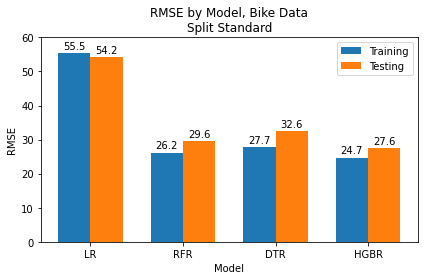

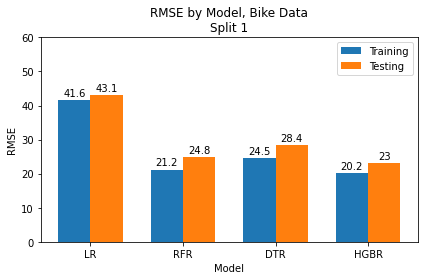

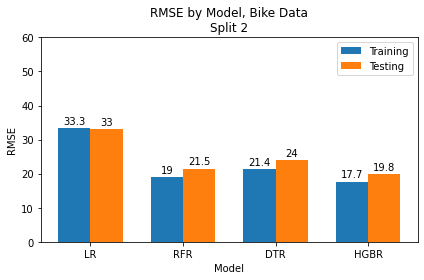

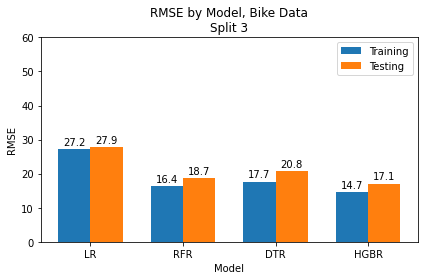

In [54]:
# plot RMSE of predictions on train and test

plot_rmse_train_test(rmse_0, 'Standard')
plot_rmse_train_test(rmse_1, 1)
plot_rmse_train_test(rmse_2, 2)
plot_rmse_train_test(rmse_3, 3)

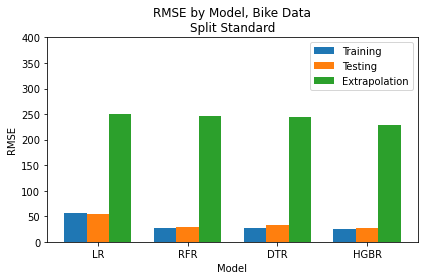

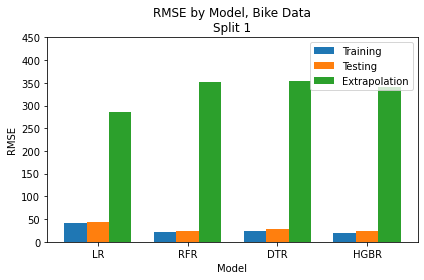

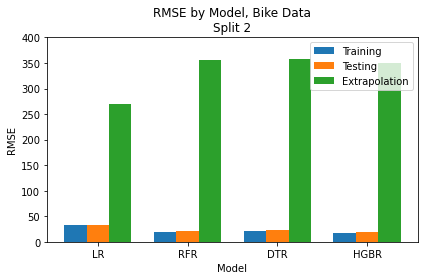

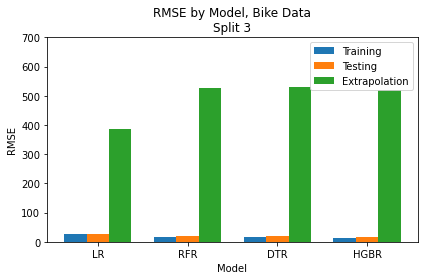

In [55]:
# plot RMSE of predictions on train, test, and extrapolation

plot_rmse_train_test_extrap(rmse_0, 'Standard', np.arange(0,401,50))
plot_rmse_train_test_extrap(rmse_1, 1, np.arange(0,500,50))
plot_rmse_train_test_extrap(rmse_2, 2, np.arange(0,450,50))
plot_rmse_train_test_extrap(rmse_3, 3, np.arange(0,701,100))



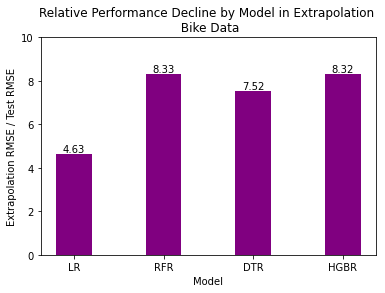

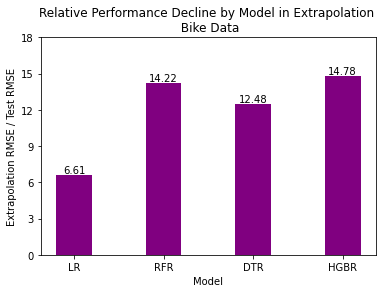

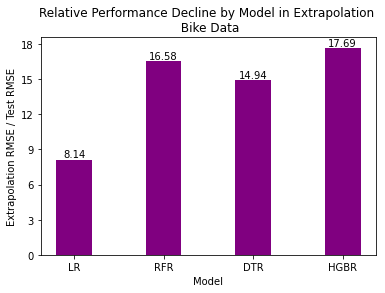

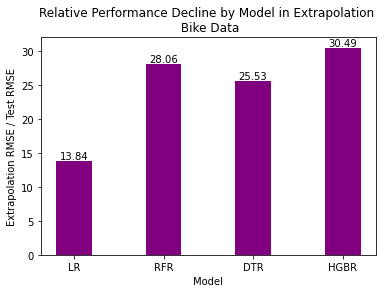

In [56]:
# plot relative difference of RMSE between extrapolation and test

plot_relative_perf(rmse_0, 'Bike Data')
plot_relative_perf(rmse_1, 'Bike Data', np.arange(0,21,3))
plot_relative_perf(rmse_2, 'Bike Data', np.arange(0,21,3))
plot_relative_perf(rmse_3, 'Bike Data', np.arange(0,35,5))

In [57]:
print('DONE!')

DONE!
